# Predicting bank's client churn

Customers have been leaving "Beta Bank," albeit slowly but noticeably, every month. Bank marketers have determined that retaining existing customers is more cost-effective than attracting new ones.

The task at hand is to predict whether a customer will leave the bank in the near future. Historical data regarding customer behavior and contract terminations with the bank have been provided. 

The project's goal is to build a model with a significantly high F1 score. The model is considered successful if the F1 score exceeds 0.59. Additionally, it is necessary to measure the AUC-ROC and compare its value with the F1 score.

Data source: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

## Preliminary Data Analysis

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import (accuracy_score, 
                             recall_score, 
                             precision_score, 
                             confusion_matrix, 
                             f1_score, 
                             roc_curve, 
                             roc_auc_score
)                             
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Импорт выглядит отлично 👍
</div>

In [2]:
data = pd.read_csv('/Users/mojseenkodenis/Desktop/Churn.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
data['Tenure'].isna().sum()

909

In [6]:
data['Tenure'].isna().sum()/len(data['Tenure']) * 100

9.09

9% of the data contains missing values; however, their quantity is not very large, so they can be removed without harming the data analysis.

In [7]:
data = data.dropna()

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        9091 non-null   int64  
 1   CustomerId       9091 non-null   int64  
 2   Surname          9091 non-null   object 
 3   CreditScore      9091 non-null   int64  
 4   Geography        9091 non-null   object 
 5   Gender           9091 non-null   object 
 6   Age              9091 non-null   int64  
 7   Tenure           9091 non-null   float64
 8   Balance          9091 non-null   float64
 9   NumOfProducts    9091 non-null   int64  
 10  HasCrCard        9091 non-null   int64  
 11  IsActiveMember   9091 non-null   int64  
 12  EstimatedSalary  9091 non-null   float64
 13  Exited           9091 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.0+ MB


In [9]:
data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [10]:
data.duplicated().sum()

0

There were no duplicates in the data, so the data is ready for training models.

Since the goal is to predict customer churn, the target feature in the study will be the "Exited" column, and the other columns will be used as features.

At the same time, the first three columns (RowNumber, CustomerId, Surname) will not be useful for prediction, so they will be removed from the final dataset.

In [11]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [12]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [13]:
target = data['Exited']
features = data.drop('Exited', axis=1)

In [14]:
#Splitting data into train, validation and testing sets in 60%-20%-20% proportion
features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, 
                                                                                        target, 
                                                                                        test_size=0.4, 
                                                                                        random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test,
                                                                            target_valid_test,
                                                                            test_size=0.5, random_state=12345)
print('Train set:', features_train.shape[0]/features.shape[0])
print('Validation set:', features_valid.shape[0]/features.shape[0])
print('Testing set:', features_test.shape[0]/features.shape[0])

Train set: 0.5999340006599934
Validation set: 0.1999780002199978
Testing set: 0.2000879991200088


In [15]:
features_train = pd.get_dummies(features_train, drop_first=True)
features_valid = pd.get_dummies(features_valid, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

Now let's scale the quantitative features: CreditScore, Age, Tenure, Balance, and EstimatedSalary.

In [16]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [17]:
#Scaling the features of the training dataset
features_train[numeric] = scaler.transform(features_train[numeric])
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9344,0.809075,-1.039327,-1.025995,0.554904,1,1,0,0.019508,0,0,0
3796,-1.152518,-1.227561,0.696524,0.480609,1,0,0,0.056167,0,0,1
7462,-0.398853,0.090079,1.385532,-1.237830,1,1,1,0.848738,0,0,1
1508,-0.749875,-0.286389,0.352020,-1.237830,2,1,1,-0.894953,0,0,1
4478,-1.028628,-0.756975,-0.336987,-1.237830,2,0,1,-1.284516,0,0,1


In [18]:
#Scaling the features of the validation dataset
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_valid.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7445,-1.369326,0.560665,-0.336987,-1.237830,1,1,0,-0.086537,0,0,0
8620,1.232367,0.090079,1.041028,-1.237830,2,0,1,-0.537457,0,0,0
1714,0.840048,0.560665,0.352020,1.231363,1,0,0,1.070393,1,0,1
5441,1.056856,-0.945210,-1.370498,0.951231,1,1,0,-0.576279,0,0,1
9001,0.406433,-0.662858,0.352020,0.767800,1,1,1,0.662068,0,1,1


In [19]:
#Scaling the features of the testing dataset
features_test[numeric] = scaler.transform(features_test[numeric])
features_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
5170,1.707279,-0.756975,-0.336987,-1.237830,2,1,1,0.718362,0,0,0
4180,-0.429826,-0.286389,1.730036,0.485538,2,0,0,1.687305,1,0,1
7349,-0.171721,0.278313,0.352020,-0.269213,2,0,1,0.824128,1,0,1
7469,0.385784,-0.380507,1.041028,0.464813,1,1,0,-1.118018,0,0,0
3467,-1.142194,0.278313,-1.370498,0.353837,2,0,1,-0.107642,1,0,0


On the first stage of the project:

 1. Data was cleaned.
 2. Unnecessary columns were removed.
 3. Categorical variables were converted into quantitative ones.
 4. The data was split into training, validation, and test sets.
 5. Quantitative variables were scaled.

In [20]:
data['Exited'].value_counts(normalize=True)

0    0.796062
1    0.203938
Name: Exited, dtype: float64

In the dataset, there are almost four times more negative instances than positive ones, so it's likely that models will predict negative values much more frequently.

First, let's look at the precision of the three models.

In [21]:
#Decision tree
best_dfc_model = None
best_dfc_result = 0
best_dfc_depth = 0

for depth in range(1, 6):
    dfc_model = DecisionTreeClassifier(random_state=12345, max_depth = depth)
    dfc_model.fit(features_train, target_train)
    dfc_predictions = dfc_model.predict(features_valid)
    dfc_result = accuracy_score(target_valid, dfc_predictions)
    if dfc_result > best_dfc_result:
        best_dfc_model = dfc_model
        best_dfc_result = dfc_result
        best_dfc_depth = depth
print('Accuracy of the most model', best_dfc_result)    
print('Depth of the best result', best_dfc_depth)

Accuracy of the most model 0.8575357535753575
Depth of the best result 5


In [22]:
#Random forest
best_model_forest = None
best_result_forest = 0
best_n_estimators = 0
best_depth = 0

for est in range(50, 200, 10):
    for depth in range(1, 11): 
        model_forest = RandomForestClassifier(random_state = 12345, n_estimators = est, max_depth=depth)
        model_forest.fit(features_train, target_train)
        result = model_forest.score(features_valid, target_valid)
        if result > best_result_forest:
            best_model_forest = model_forest
            best_result_forest = result
            best_n_estimators = est
            best_depth = depth
print('Accuracy of the most model', best_result_forest)    
print('n estimators of the best result', best_n_estimators)        
print('Depth of the best result', best_depth)   

Accuracy of the most model 0.8641364136413642
n estimators of the best result 50
Depth of the best result 10


In [23]:
#Linear regression
best_model_reg = None
best_result_reg = 0
best_max_iter = 0
best_c_value = 0

for c_value in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]: 
    for iter in range(100, 1000, 100):
        model_regression = LogisticRegression(random_state=12345, C = c_value, solver='liblinear', max_iter=iter)
        model_regression.fit(features_train, target_train)
        model_regression.predict(features_valid)
        result_regression = model_regression.score(features_valid, target_valid)
        if result_regression > best_result_reg:
            best_model_reg = model_regression
            best_result_reg = result_regression
            best_max_iter = iter
            best_c_value = c_value
        
print('Accuracy of the regression:', best_result_reg)
print('Best max_iter:', best_max_iter)
print('Best c_value:', best_c_value)

Accuracy of the regression: 0.8085808580858086
Best max_iter: 100
Best c_value: 0.1


Random forest showed the best result wiht the precision rate of 0.864.

In [24]:
dfc_share = pd.Series(dfc_model.predict(features_valid)).value_counts(normalize = 1)
forest_share = pd.Series(model_forest.predict(features_valid)).value_counts(normalize = 1)
regression_share = pd.Series(model_regression.predict(features_valid)).value_counts(normalize = 1)
print(dfc_share)
print(forest_share)
print(regression_share)

0    0.914191
1    0.085809
dtype: float64
0    0.887789
1    0.112211
dtype: float64
0    0.931793
1    0.068207
dtype: float64


All models ultimately predict negative values more often.

Let's take a closer look at the parameters of each model individually.

In [25]:
#Confusion matrix for the Decision Tree model
dfc_model = DecisionTreeClassifier(random_state=12345, max_depth = 5)
dfc_model.fit(features_train, target_train)
dfc_predictions = dfc_model.predict(features_valid)
confusion_matrix(target_valid, dfc_predictions)

array([[1422,   19],
       [ 240,  137]])

In [26]:
#Creating function for the metrics
def metrics(target_valid, prediction):
    print("Recall" , recall_score(target_valid, prediction))
    print("Precision", precision_score(target_valid, prediction))
    print("F1-score", f1_score(target_valid, prediction))
    print("AUC-ROC", roc_auc_score(target_valid, prediction))

In [27]:
metrics(target_valid, dfc_predictions)

Recall 0.363395225464191
Precision 0.8782051282051282
F1-score 0.5140712945590994
AUC-ROC 0.6751049687348714


In [28]:
#Confusion matrix for the Random Forest model
model_forest = RandomForestClassifier(random_state = 12345, n_estimators = 50, max_depth=10)
model_forest.fit(features_train, target_train)
forest_predictions = model_forest.predict(features_valid)
confusion_matrix(target_valid, forest_predictions)

array([[1402,   39],
       [ 208,  169]])

In [29]:
metrics(target_valid, forest_predictions)

Recall 0.4482758620689655
Precision 0.8125
F1-score 0.5777777777777777
AUC-ROC 0.7106056617770227


In [30]:
#Confusion matrix for the Linear Regression model
model_regression = LogisticRegression(random_state=12345, C = 100, solver='liblinear', max_iter=900)
model_regression.fit(features_train, target_train)
regression_predictions = model_regression.predict(features_valid)
confusion_matrix(target_valid, regression_predictions)

array([[1393,   48],
       [ 301,   76]])

In [31]:
metrics(target_valid, regression_predictions)

Recall 0.20159151193633953
Precision 0.6129032258064516
F1-score 0.3033932135728543
AUC-ROC 0.5841406553436035


The F1 scores for all models are relatively low due to low recall values, and all models predict negative values much more frequently than positive ones.

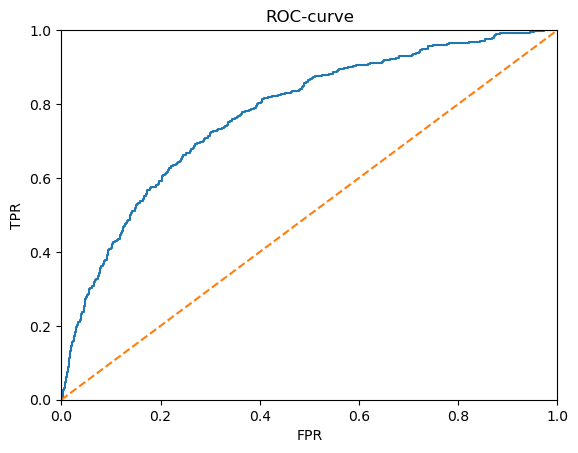

In [32]:
#ROC-curve for Linear Regression
probabilities_valid = model_regression.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

frp, trp, threshold = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(frp, trp)
plt.plot([0, 1], [0, 1], ls='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-curve')
plt.show()

In [33]:
roc_auc_score(target_valid, probabilities_one_valid)

0.7735859823251243

The metric is better than that of a random model but doesn't quite reach the ideal of 1.

In the end, three models were investigated with the following results:

 - Decision Tree: Precision 0.857
 - Random Forest: Precision 0.864
 - Logistic Regression: Precision 0.808

However, the high results are associated with the fact that the models predict negative results more often because there are four times more negative objects in the original dataset.

Furthermore, the metric calculations showed that all models have F1 scores (0.514, 0.577, 0.303) that do not reach the target of 0.59 due to low recall values.

## Eliminating data imbalance

**Oversampling**

Let's correct the imbalance of objects, first by increasing the proportion of positive objects in the new training sample.

In [34]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [35]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
print(target_upsampled.value_counts(normalize = 1))
print(features_upsampled.shape)
print(target_upsampled.shape)

1    0.509964
0    0.490036
Name: Exited, dtype: float64
(8832, 11)
(8832,)


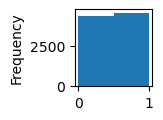

In [36]:
target_upsampled.plot(kind ='hist', bins=2, figsize=(1,1));

Now, positive and negative objects are roughly in the same proportions. Let's train the models on the new data.

In [37]:
#Decision tree
best_dfc_model_up = None
best_dfc_result_up = 0
best_dfc_depth_up = 0

for depth in range(1, 6):
    dfc_model_up = DecisionTreeClassifier(random_state=12345, max_depth = depth)
    dfc_model_up.fit(features_upsampled, target_upsampled)
    dfc_predictions_up = dfc_model_up.predict(features_valid)
    dfc_result_up = accuracy_score(target_valid, dfc_predictions_up)
    if dfc_result_up > best_dfc_result_up:
        best_dfc_model_up = dfc_model_up
        best_dfc_result_up = dfc_result_up
        best_dfc_depth_up = depth
print('Accuracy of the best model', best_dfc_result_up)    
print('Depth of the best result', best_dfc_depth_up)

Accuracy of the best model 0.7783278327832783
Depth of the best result 5


In [38]:
#Random forest
best_model_forest_up = None
best_result_forest_up = 0
best_n_estimators_up = 0
best_depth = 0

for est in range(50, 200, 10):
    for depth in range(1, 11): 
        model_forest_up = RandomForestClassifier(random_state = 12345, n_estimators = est, max_depth=depth)
        model_forest_up.fit(features_upsampled, target_upsampled)
        result_up = model_forest_up.score(features_valid, target_valid)
        if result_up > best_result_forest_up:
            best_model_forest_up = model_forest_up
            best_result_forest_up = result_up
            best_n_estimators_up = est
            best_depth_up = depth
print('Accuracy of the best model', best_result_forest_up)    
print('n estimators of the best result', best_n_estimators_up)        
print('Depth of the best result', best_depth_up)   

Accuracy of the best model 0.8322332233223322
n estimators of the best result 190
Depth of the best result 10


In [39]:
#Linear regression
best_model_reg_up = None
best_result_reg_up = 0
best_max_iter_up = 0
best_c_value_up = 0

for c_value in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]: 
    for iter in range(100, 1000, 100):
        model_regression_up = LogisticRegression(random_state=12345, C = c_value, solver='liblinear', max_iter=iter)
        model_regression_up.fit(features_upsampled, target_upsampled)
        model_regression_up.predict(features_valid)
        result_regression_up = model_regression_up.score(features_valid, target_valid)
        if result_regression_up > best_result_reg_up:
            best_model_reg_up = model_regression_up
            best_result_reg_up = result_regression_up
            best_max_iter_up = iter
            best_c_value_up = c_value
        
print('Accuracy:', best_result_reg_up)
print('Best max_iter:', best_max_iter_up)
print('Best c_value:', best_c_value_up)

Accuracy: 0.7145214521452146
Best max_iter: 100
Best c_value: 0.001


Here are the new results compared to the previous ones:

 - Decision Tree: 0.857 vs 0.778
 - Random Forest: 0.864 vs 0.832
 - Linear Regression: 0.808 vs 0.714

The accuracy of the models decreased after addressing the imbalance issue. Let's now take a closer look at the metrics.

In [40]:
#Decision tree
dfc_model_up = DecisionTreeClassifier(random_state=12345, max_depth = 5)
dfc_model_up.fit(features_upsampled, target_upsampled)
dfc_predictions_up = dfc_model_up.predict(features_valid)
metrics(target_valid, dfc_predictions_up)

Recall 0.7188328912466844
Precision 0.477112676056338
F1-score 0.5735449735449736
AUC-ROC 0.7563630105088384


In [41]:
#Random forest
model_forest_up = RandomForestClassifier(random_state = 12345, n_estimators = 190, max_depth=10)
model_forest_up.fit(features_upsampled, target_upsampled)
forest_predictions_up = model_forest_up.predict(features_valid)
metrics(target_valid, forest_predictions_up)

Recall 0.7055702917771883
Precision 0.5782608695652174
F1-score 0.6356033452807646
AUC-ROC 0.7854707808643056


In [42]:
#Linear regression
model_regression_up = LogisticRegression(random_state=12345, 
                                         C = 0.001, 
                                         solver='liblinear', 
                                         max_iter=100, 
                                         class_weight='balanced')
model_regression_up.fit(features_upsampled, target_upsampled)
regression_predictions_up = model_regression_up.predict(features_valid)
metrics(target_valid, regression_predictions_up)

Recall 0.6843501326259946
Precision 0.4050235478806907
F1-score 0.5088757396449703
AUC-ROC 0.7106691676315261


All three models showed an increase in their f1-score due to improved recall:

 - Decision Tree: 0.514 vs. 0.573
 - Random Forest: 0.577 vs. 0.635
 - Linear Regression: 0.303 vs. 0.508

In the end, the Random Forest model with 190 estimators and a depth of 10 performed the best, achieving an f1-score of 0.63.

**Undersampling**

Now, let's try to correct the imbalance by reducing the proportion of negative objects in the training dataset.

In [43]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [44]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

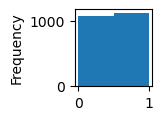

In [45]:
target_downsampled.plot(kind ='hist', bins=2, figsize=(1,1));

In [46]:
target_upsampled.value_counts(normalize=True)

1    0.509964
0    0.490036
Name: Exited, dtype: float64

Now that positive and negative objects are roughly balanced, let's try training the models using the new reduced dataset.

In [47]:
#Decision tree
best_dfc_model_down = None
best_dfc_result_down = 0
best_dfc_depth_down = 0

for depth in range(1, 6):
    dfc_model_down = DecisionTreeClassifier(random_state=12345, max_depth = depth)
    dfc_model_down.fit(features_downsampled, target_downsampled)
    dfc_predictions_down = dfc_model_down.predict(features_valid)
    dfc_result_down = accuracy_score(target_valid, dfc_predictions_down)
    if dfc_result_down > best_dfc_result_down:
        best_dfc_model_down = dfc_model_down
        best_dfc_result_down = dfc_result_down
        best_dfc_depth_down = depth
print('Accuracy of the best model', best_dfc_result_down)    
print('Depth of the best result', best_dfc_depth_down)

Accuracy of the best model 0.7508250825082509
Depth of the best result 4


In [48]:
#Random forest
best_model_forest_down = None
best_result_forest_down = 0
best_n_estimators_down = 0
best_depth_down = 0

for est in range(50, 200, 10):
    for depth in range(1, 11): 
        model_forest_down = RandomForestClassifier(random_state = 12345, n_estimators = est, max_depth=depth)
        model_forest_down.fit(features_downsampled, target_downsampled)
        result_down = model_forest_down.score(features_valid, target_valid)
        if result_down > best_result_forest_down:
            best_model_forest_down = model_forest_down
            best_result_forest_down = result_down
            best_n_estimators_down = est
            best_depth_down = depth
print('Accuracy of the best model', best_result_forest_down)    
print('n estimators of the best result', best_n_estimators_down)        
print('Depth of the best result', best_depth_down)   

Accuracy of the best model 0.7849284928492849
n estimators of the best result 190
Depth of the best result 10


In [49]:
#Linear regression
best_model_reg_down = None
best_result_reg_down = 0
best_max_iter_down = 0
best_c_value_down = 0

for c_value in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]: 
    for iter in range(100, 1000, 100):
        model_regression_down = LogisticRegression(random_state=12345, C = c_value, solver='liblinear', max_iter=iter)
        model_regression_down.fit(features_downsampled, target_downsampled)
        model_regression_down.predict(features_valid)
        result_regression_down = model_regression_down.score(features_valid, target_valid)
        if result_regression_down > best_result_reg_down:
            best_model_reg_down = model_regression_down
            best_result_reg_down = result_regression_down
            best_max_iter_down = iter
            best_c_value_down = c_value
        
print('Accuracy:', best_result_reg_down)
print('Best max_iter:', best_max_iter_down)
print('Best c_value:', best_c_value_down)

Accuracy: 0.7057205720572057
Best max_iter: 100
Best c_value: 0.01


Let's compare the new results (3rd number) with the results before correcting the imbalance (1st) and with the increased dataset (2nd):

 - Decision Tree: 0.857 vs 0.778 vs 0.75
 - Random Forest: 0.864 vs 0.832 vs 0.784
 - Linear Regression: 0.808 vs 0.714 vs 0.705

All models showed lower accuracy compared to the previous ones. Let's then look at the metrics for the new models.

In [50]:
#Decision tree
dfc_model_down = DecisionTreeClassifier(random_state=12345, max_depth = 4)
dfc_model_down.fit(features_downsampled, target_downsampled)
dfc_predictions_down = dfc_model_down.predict(features_valid)
metrics(target_valid, dfc_predictions_down)

Recall 0.753315649867374
Precision 0.4409937888198758
F1-score 0.5563173359451519
AUC-ROC 0.7517445702494399


In [51]:
#Random forest
model_forest_down = RandomForestClassifier(random_state = 12345, n_estimators = 190, max_depth=10)
model_forest_down.fit(features_downsampled, target_downsampled)
forest_predictions_down = model_forest_down.predict(features_valid)
metrics(target_valid, forest_predictions_down)

Recall 0.8090185676392573
Precision 0.48878205128205127
F1-score 0.6093906093906094
AUC-ROC 0.7938222609188653


In [52]:
#Linear regression
model_regression_down = LogisticRegression(random_state=12345, 
                                         C = 0.01, 
                                         solver='liblinear', 
                                         max_iter=100, 
                                         class_weight='balanced')
model_regression_down.fit(features_downsampled, target_downsampled)
regression_predictions_down = model_regression_down.predict(features_valid)
metrics(target_valid, regression_predictions_down)

Recall 0.6976127320954907
Precision 0.3984848484848485
F1-score 0.5072324011571842
AUC-ROC 0.7110548046320618


F1-score metrics:

 - Decision Tree: 0.514 (before imbalance correction) vs 0.573 (increased dataset) vs 0.556 (decreased dataset)
 - Random Forest: 0.577 vs 0.635 vs 0.609
 - Linear Regression: 0.303 vs 0.508 vs 0.507

In total, reducing the dataset size as a way to combat imbalance did not lead to an increase in model accuracy. Therefore, for training and testing the final model, we will use the Random Forest model with 190 estimators and a depth of 10, which showed the best result.

## Model testing

Let's test the final model

In [53]:
model_test = RandomForestClassifier(random_state = 12345, n_estimators = 190, max_depth=10)
model_test.fit(features_upsampled, target_upsampled)
predictions_test = model_test.predict(features_test)
result_test = accuracy_score(target_test, predictions_test)
print('Accuracy:', result_test)
metrics(target_test, predictions_test)

Accuracy: 0.817482133040132
Recall 0.6723646723646723
Precision 0.5209713024282561
F1-score 0.5870646766169154
AUC-ROC 0.762272254438467


In [54]:
#Let's create a constant model.
target_predict_constant = pd.Series([0]*len(target_test))
target_predict_constant.value_counts(normalize=True)

0    1.0
dtype: float64

In [55]:
print(f'Accuracy - {accuracy_score(target_test, target_predict_constant)}')
print(f'AUC-ROC - {roc_auc_score(target_test, target_predict_constant)}')

Accuracy - 0.8070368334249588
AUC-ROC - 0.5


Результаты итоговой модели выше, чем у константной и по точности (0.817 vs 0.807), и по AUC-ROC (0.762 vs 0.5), так что можно утверждать, что модель работает адекватно.

## Conclusion

In this study, various models were explored for predicting customer churn in "Beta Bank."

Initially, models were trained on data with a large number of negative cases (80% negative vs. 20% positive). All models (decision tree, random forest, linear regression) showed good accuracy (0.857, 0.864, 0.808) but had low F1-score (0.514, 0.577, 0.303) due to low precision, as the models mostly predicted negative cases.

Two methods were attempted to address the class imbalance: oversampling and undersampling. In both cases, the random forest model performed the best with the highest F1-score (0.635 and 0.609). Oversampling showed higher accuracy compared to undersampling (0.832 vs. 0.784 for random forest).

The test model provided the following results:

 - Accuracy: 0.817
 - Recall: 0.672
 - Precision: 0.52
 - F1-score: 0.587
 - AUC-ROC: 0.762

The test model also outperformed the constant model, indicating its adequacy. However, precision and recall are low, suggesting that the model will correctly predict only about half of the customer churn cases.